   ***NOTE;THIS NOTEBOOK WAS RUNNED ON KAGGLE!!!!***
# **Adbot Ad Engagement Forecasting Challenge**
Can you predict the future success of a digital advert?

https://zindi.africa/competitions/adbot-ad-engagement-forecasting-challenge

**Description:**
In a digital ecosystem saturated with advertisements, accurately predicting success is pivotal for businesses. Adbot aims to empower its small business clients with actionable insights to refine their ad campaigns and bolster customer engagement.

The objective of this challenge is to accurately predict the number of clicks a client’s ad receives, one and two weeks into the future (in digital marketing, clicks refer to when someone views the advert and follows one of the hyperlinks in that advert). Winning solutions will further be required to submit a description of the variables that had the most significant impact on engagement (number of clicks). It is therefore important that the models you build are not only accurate, but also interpretable.

Solving this problem holds immense potential for the small African businesses leveraging the Adbot platform. Accurate ad impression and click-through-rate forecasting can revolutionise marketing strategies, enabling businesses to allocate resources effectively and maximise ad campaign ROI. By providing actionable insights, Adbot empowers clients to optimise their advertising efforts, improving customer engagement and driving business growth.


Name **Emmanuel Ebiendele**

**Username: Ebiendele**

Private Leaderboard Rank; **5th**

PRIVATE LEADERBOARD SCORE; **13.88451155**

PUBLIC LEADERBOARD SCORE; **33.21064205**

https://zindi.africa/competitions/adbot-ad-engagement-forecasting-challenge/leaderboard

# **STEP 1; Importing Library Packages**

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# **STEP 2; Loading Datasets**

In [2]:
# Load the datasets
train_data_path = '/kaggle/input/adbotforecasting/Train.csv'
sample_submission_path = '/kaggle/input/adbotforecasting/SampleSubmission.csv'

train_data = pd.read_csv(train_data_path)
sample_submission = pd.read_csv(sample_submission_path)

# **STEP 3; VIEWING THE DATA**

In [3]:
# Display the first few rows of each dataset to understand their structure
train_data.head(), sample_submission.head()

(   impressions  clicks    cost  conversions           ad_type currency  \
 0        142.0    15.0  3393.0          0.0  EXPANDED_TEXT_AD      ZAR   
 1         89.0     8.0  1817.0          0.0  EXPANDED_TEXT_AD      ZAR   
 2         59.0     8.0  1743.0          0.0  EXPANDED_TEXT_AD      ZAR   
 3         78.0     4.0   917.0          0.0  EXPANDED_TEXT_AD      ZAR   
 4         20.0     1.0   217.0          0.0  EXPANDED_TEXT_AD      ZAR   
 
                             ID        date call_type call_status start_time  \
 0  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 1  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 2  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 3  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 4  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 
    duration end_time display_location  impression_share  conversi

# **STEP 4: Data Aggregation**

In [4]:
# Aggregating the train data by ID and date
aggregated_data = train_data.groupby(['ID', 'date']).agg({'clicks': 'sum'}).reset_index()

# Checking the aggregated data
aggregated_data.head()

,ID,date,clicks
0,ID_5da86e71bf5dee4cf5047046,2020-01-01,36.0
1,ID_5da86e71bf5dee4cf5047046,2020-01-02,50.0
2,ID_5da86e71bf5dee4cf5047046,2020-01-03,54.0
3,ID_5da86e71bf5dee4cf5047046,2020-01-04,47.0
4,ID_5da86e71bf5dee4cf5047046,2020-01-05,59.0


Aggregates the training data by 'ID' and 'date' columns, summing up the 'clicks', and displays the aggregated data.

# **STEP 5; Converts the 'date' column in the aggregated data to datetime format**

In [5]:
from datetime import datetime

# Convert 'date' columns to datetime for both datasets
aggregated_data['date'] = pd.to_datetime(aggregated_data['date'])
#sample_submission['date'] = sample_submission['ID'].apply(lambda x: datetime.strptime(x.split('_')[-1], "%Y_%m_%d"))

# Add the pure ID to the sample submission for merging purposes
#sample_submission['pure_id'] = sample_submission['ID'].apply(lambda x: '_'.join(x.split('_')[:-3]))

# Check the transformation and creation of new columns
sample_submission.head()

,ID,clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0
2,ID_5e43c29e6279884e2827d894_2024_02_21,0
3,ID_5e43c29e6279884e2827d894_2024_02_28,0
4,ID_5e4e7b480e374330ee151305_2023_12_04,0


In [6]:
# Show some sample IDs from the sample submission file to check the date format
sample_submission['ID'].head()

0    ID_5da86e71bf5dee4cf5047046_2024_01_22
1    ID_5da86e71bf5dee4cf5047046_2024_01_29
2    ID_5e43c29e6279884e2827d894_2024_02_21
3    ID_5e43c29e6279884e2827d894_2024_02_28
4    ID_5e4e7b480e374330ee151305_2023_12_04
Name: ID, dtype: object

# **STEP 6; parse the date from the ID**

In [7]:
# Correctly parse the date from the ID
sample_submission['date'] = sample_submission['ID'].apply(lambda x: datetime.strptime('_'.join(x.split('_')[-3:]), "%Y_%m_%d"))

# Add the pure ID to the sample submission for merging purposes
sample_submission['pure_id'] = sample_submission['ID'].apply(lambda x: '_'.join(x.split('_')[:-3]))

# Display the transformed sample submission
sample_submission.head()

,ID,clicks,date,pure_id
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0,2024-01-22,ID_5da86e71bf5dee4cf5047046
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0,2024-01-29,ID_5da86e71bf5dee4cf5047046
2,ID_5e43c29e6279884e2827d894_2024_02_21,0,2024-02-21,ID_5e43c29e6279884e2827d894
3,ID_5e43c29e6279884e2827d894_2024_02_28,0,2024-02-28,ID_5e43c29e6279884e2827d894
4,ID_5e4e7b480e374330ee151305_2023_12_04,0,2023-12-04,ID_5e4e7b480e374330ee151305


# **STEP 7; MODELLING**

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare the data for the model
# Convert date to ordinal to use as a feature
aggregated_data['date_ordinal'] = aggregated_data['date'].apply(lambda x: x.toordinal())

# Extract only IDs present in the sample submission
ids_in_submission = sample_submission['pure_id'].unique()
filtered_data = aggregated_data[aggregated_data['ID'].isin(ids_in_submission)]

# Model training
# As IDs could have different patterns, we will create a model per ID, then predict accordingly
models = {}
for id_value in ids_in_submission:
    data_subset = filtered_data[filtered_data['ID'] == id_value]
    if len(data_subset) > 1:  # Ensure there's enough data to fit a model
        X = data_subset[['date_ordinal']]
        y = data_subset['clicks']
        model = CatBoostRegressor(n_estimators =45,learning_rate = 0.04, verbose=0, random_state=42)
        model.fit(X, y)
        models[id_value] = model

# Function to forecast clicks
def forecast_clicks(row):
    model = models.get(row['pure_id'])
    if model:
        prediction = model.predict(np.array([[row['date'].toordinal()]]))
        return int(prediction[0])
    return 0  # Default to 0 if no model is found for the ID

# Apply forecast to the sample submission data
sample_submission['predicted_clicks'] = sample_submission.apply(forecast_clicks, axis=1)
sample_submission.head()

,ID,clicks,date,pure_id,predicted_clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0,2024-01-22,ID_5da86e71bf5dee4cf5047046,100
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0,2024-01-29,ID_5da86e71bf5dee4cf5047046,100
2,ID_5e43c29e6279884e2827d894_2024_02_21,0,2024-02-21,ID_5e43c29e6279884e2827d894,4
3,ID_5e43c29e6279884e2827d894_2024_02_28,0,2024-02-28,ID_5e43c29e6279884e2827d894,4
4,ID_5e4e7b480e374330ee151305_2023_12_04,0,2023-12-04,ID_5e4e7b480e374330ee151305,4


In [9]:
submission = pd.DataFrame({"ID":sample_submission['ID'], "Clicks": sample_submission['predicted_clicks']})
submission.to_csv("winpred_1s_t_0_1_eb.csv", index=False)

In [10]:
submission.head()

,ID,Clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,100
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,100
2,ID_5e43c29e6279884e2827d894_2024_02_21,4
3,ID_5e43c29e6279884e2827d894_2024_02_28,4
4,ID_5e4e7b480e374330ee151305_2023_12_04,4


# **SENSITIVITY ANALYSIS**

In [11]:
import pandas as pd

# Load the Train.csv file
train_data_path = '/kaggle/input/adbotforecasting/Train.csv'
train_data = pd.read_csv(train_data_path)

# Display the first few rows and the structure of the data
train_data.head(), train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289926 entries, 0 to 289925
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   impressions         289526 non-null  float64
 1   clicks              289526 non-null  float64
 2   cost                289526 non-null  float64
 3   conversions         289526 non-null  float64
 4   ad_type             289526 non-null  object 
 5   currency            289526 non-null  object 
 6   ID                  289926 non-null  object 
 7   date                289926 non-null  object 
 8   call_type           36900 non-null   object 
 9   call_status         36900 non-null   object 
 10  start_time          36900 non-null   object 
 11  duration            36900 non-null   float64
 12  end_time            36900 non-null   object 
 13  display_location    36900 non-null   object 
 14  impression_share    289926 non-null  float64
 15  conversions_calls   280071 non-nul

(   impressions  clicks    cost  conversions           ad_type currency  \
 0        142.0    15.0  3393.0          0.0  EXPANDED_TEXT_AD      ZAR   
 1         89.0     8.0  1817.0          0.0  EXPANDED_TEXT_AD      ZAR   
 2         59.0     8.0  1743.0          0.0  EXPANDED_TEXT_AD      ZAR   
 3         78.0     4.0   917.0          0.0  EXPANDED_TEXT_AD      ZAR   
 4         20.0     1.0   217.0          0.0  EXPANDED_TEXT_AD      ZAR   
 
                             ID        date call_type call_status start_time  \
 0  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 1  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 2  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 3  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 4  ID_5da86e71bf5dee4cf5047046  2020-01-01       NaN         NaN        NaN   
 
    duration end_time display_location  impression_share  conversi

The data includes the following columns with a variety of data types and some missing values:

Numerical: impressions, clicks, cost, conversions, duration, impression_share, conversions_calls, headline1_len, headline2_len, ad_description_len
Categorical: ad_type, currency, call_type, call_status, display_location
ID and Time: ID, date, start_time, end_time

Next, I will aggregate this data by ID and all other available features. This involves grouping by ID and aggregating numerical columns such as impressions, clicks, cost, etc. I'll also handle missing values appropriately, either by filling or excluding them based on their impact.

In [12]:
# Correcting the aggregation code
aggregated_data = train_data.groupby('ID').agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'cost': 'sum',
    'conversions': 'sum',
    'duration': 'sum',
    'impression_share': 'mean',  # mean might be more informative for share metrics
    'conversions_calls': 'sum',
    'headline1_len': 'mean',  # average length across ads
    'headline2_len': 'mean',
    'ad_description_len': 'mean'  # average length of ad descriptions
}).reset_index()

# Display the aggregated data to ensure it's aggregated correctly
aggregated_data.head()

,ID,impressions,clicks,cost,conversions,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,ID_5da86e71bf5dee4cf5047046,1366246.0,117103.0,19151427.0,68.0,70766.0,17.920390,769.0,1.981056,2.167063,11.027789
1,ID_5e43c29e6279884e2827d894,164422.0,10841.0,4320985.0,1.0,1115.0,9.118905,4.0,2.695326,2.953855,12.267206
2,ID_5e4e7b480e374330ee151305,213592.0,10940.0,5425830.0,33.0,24103.0,8.915555,105.0,2.778545,2.419012,13.166490
3,ID_5e8ad56cd4090270567b6c58,556700.0,39586.0,12001897.0,155.0,0.0,8.045458,0.0,2.141866,2.260493,12.068332
4,ID_5e8b4f12d8709943490cd775,172329.0,9278.0,3373154.0,1.0,0.0,7.498799,2.0,1.913960,3.844601,13.538191


The data has been successfully aggregated by ID, summing up values for impressions, clicks, cost, conversions, and duration. We also calculated the mean for impression_share, headline1_len, headline2_len, and ad_description_len.

Next, let's conduct the sensitivity analysis. We will investigate how changes in the top five variables affect the total number of clicks (clicks). For this, we will use techniques such as partial dependence plots or other appropriate methods to assess the impact of each variable on clicks independently. This will help us understand how much each of these variables needs to change to potentially improve the total number of clicks.

To perform the sensitivity analysis, we will first identify the top five variables that most strongly correlate with the number of clicks. After identifying these variables, we will use sensitivity analysis techniques to determine how changes in these variables could potentially influence the number of clicks.

Here’s the plan:

1) Identify the top five most influential variables based on correlation with clicks.

2) Perform sensitivity analysis on these variables to understand their independent effect on clicks.

In [13]:
# Select only numeric columns for calculating the correlation matrix
numeric_data = aggregated_data.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Extract the correlation of all variables with 'clicks'
clicks_correlation = correlation_matrix['clicks'].sort_values(ascending=False)

# Display the top five variables most correlated with clicks
top_five_variables = clicks_correlation.index[1:6]  # Skipping the first index because it will be 'clicks' itself
top_five_variables, clicks_correlation[top_five_variables]

(Index(['impressions', 'cost', 'conversions_calls', 'duration', 'conversions'], dtype='object'),
 impressions          0.794944
 cost                 0.570198
 conversions_calls    0.388570
 duration             0.360603
 conversions          0.300673
 Name: clicks, dtype: float64)

***The top five variables most strongly correlated with clicks are:****

**Impressions**: Correlation coefficient of 0.795

**Cost**: Correlation coefficient of 0.570

**Conversions Calls**: Correlation coefficient of 0.389

**Duration**: Correlation coefficient of 0.361

**Conversions**: Correlation coefficient of 0.301

*Next, I will perform a sensitivity analysis on these variables. USING **partial dependence plots (PDP)** to visually examine how changes in these variables might impact the number of clicks. This method will allow us to isolate the effect of each variable while averaging out the effects of others, providing a clearer view of each variable's impact on clicks.*

In [14]:
# Selecting a subset of the data for the analysis to avoid high computational cost
sample_data = aggregated_data.sample(n=min(1000, len(aggregated_data)), random_state=42)

# Define features and target
X = sample_data[list(top_five_variables)]
y = sample_data['clicks']

In [15]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

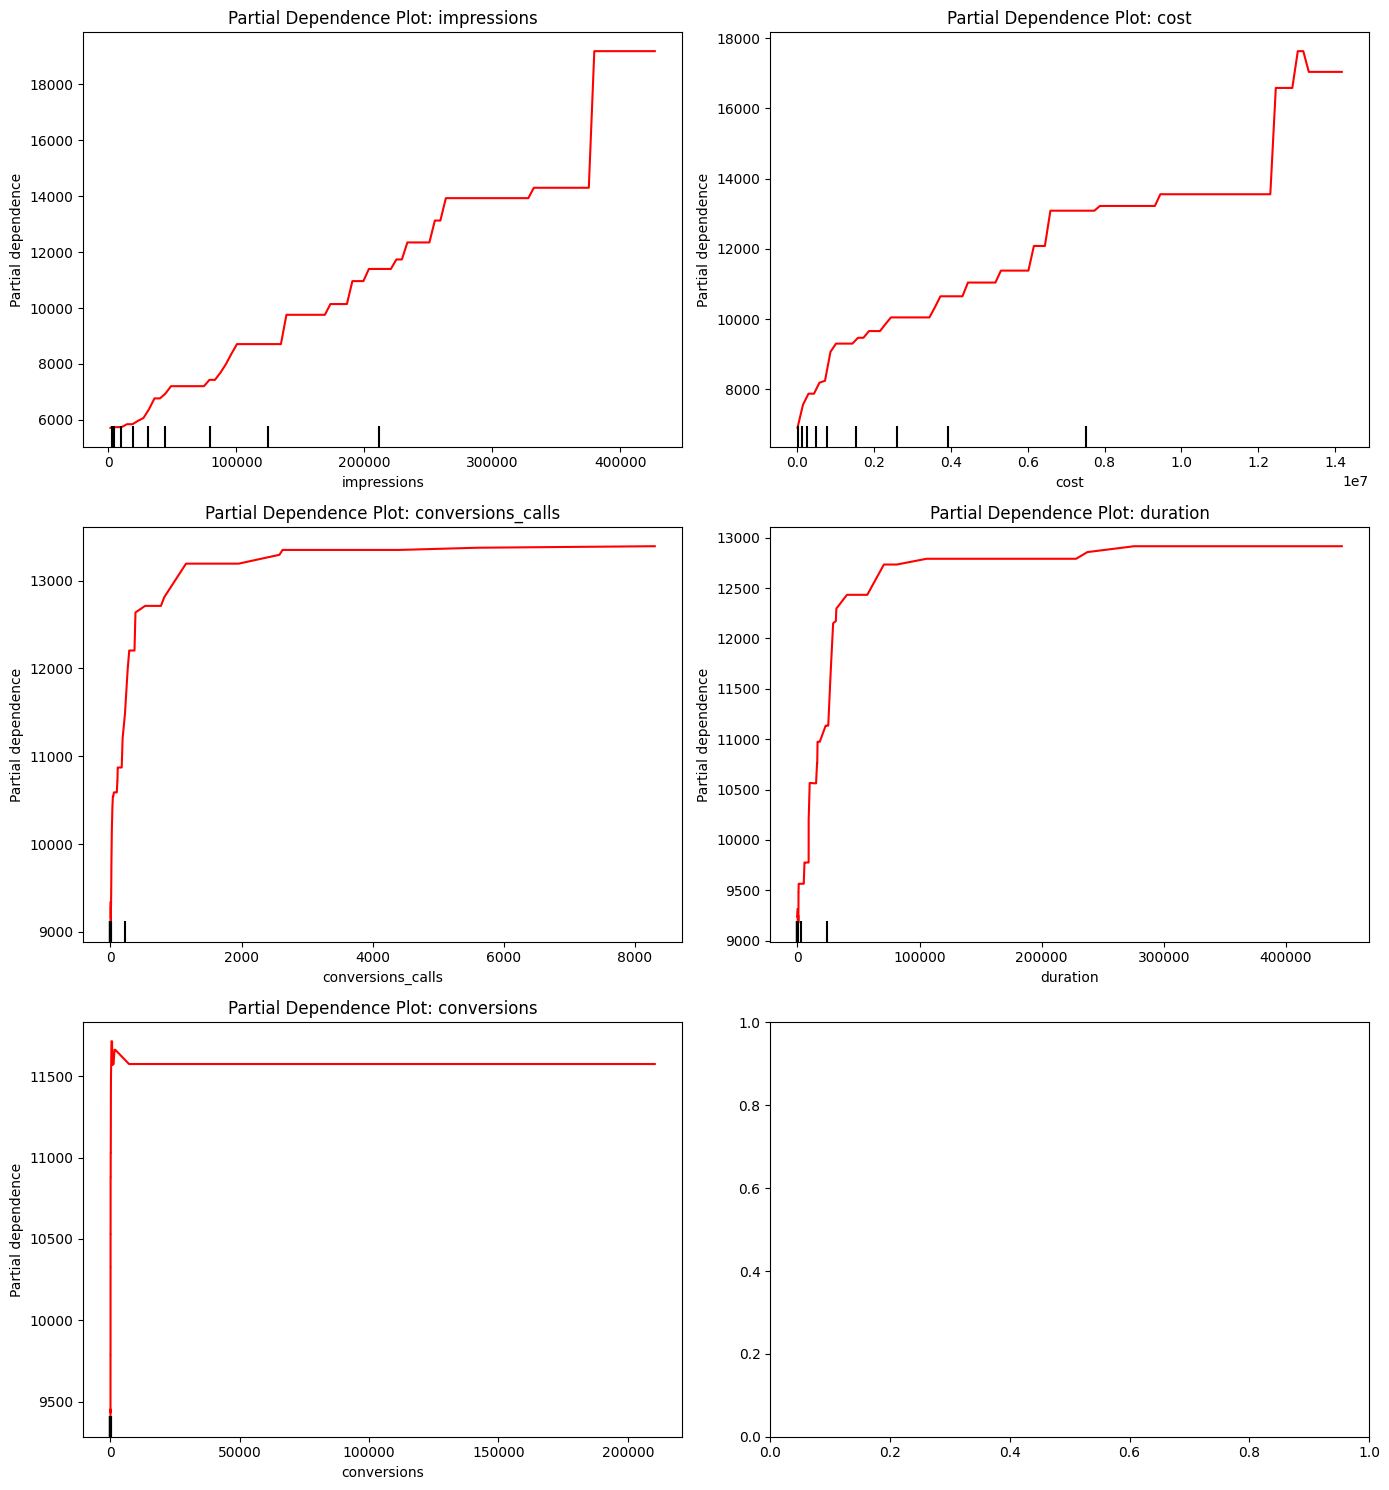

In [16]:
from sklearn.inspection import PartialDependenceDisplay

# Train a CATBOOST model again for demonstration
model = CatBoostRegressor(n_estimators =45,learning_rate = 0.04, verbose=0, random_state=42)
model.fit(X, y)

# Create partial dependence plots for the top five variables using the new method
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(14, 15))
for i, var in enumerate(top_five_variables):
    disp = PartialDependenceDisplay.from_estimator(model, X, features=[var], ax=axs[i//2, i%2], line_kw={'color': 'red'})
    axs[i//2, i%2].set_title(f'Partial Dependence Plot: {var}')

# Adjust layout and display the plots
fig.tight_layout()
plt.show()


**The partial dependence plots provide valuable insights into how each of the top variables affects the predicted number of clicks independently, while holding other variables constant at their average values. Let’s analyze each plot in detail:**

### 1. Impressions
- **Observation**: The plot shows a clear and consistent upward trend. As the number of impressions increases, the predicted number of clicks also increases.
- **Interpretation**: This suggests a strong positive relationship between the number of impressions and clicks. Increasing impressions generally leads to more clicks, which can be due to higher exposure and reach of the ad.

### 2. Cost
- **Observation**: There is a progressive increase in predicted clicks with increasing costs, with a few plateau phases followed by sharp increases.
- **Interpretation**: The steps or jumps in the plot may indicate thresholds in spending after which additional increments in budget contribute to noticeable increases in clicks. This could be tied to bidding strategies in ad placements, where certain budget thresholds allow for better ad placements or more competitive bids.

### 3. Conversions Calls
- **Observation**: The number of clicks increases steeply as the number of conversions from calls increases initially, and then it plateaus after a certain point.
- **Interpretation**: This indicates that conversions from calls have a significant impact on clicks up to a certain level. After reaching this level, further increases in conversions from calls do not significantly impact the number of clicks, suggesting a saturation point where other factors might limit further gains.

### 4. Duration
- **Observation**: Similar to conversions from calls, there's an initial sharp increase in clicks as the duration increases, followed by a plateau.
- **Interpretation**: This shows that longer interactions or engagements (as measured by duration) are associated with higher clicks initially, which could indicate effective engagement with interested users. The plateau suggests a maximum effectiveness threshold for duration beyond which additional time does not translate into more clicks.

### 5. Conversions
- **Observation**: The clicks increase sharply with a small initial increase in conversions and then level off for the rest of the conversions range.
- **Interpretation**: The initial sharp increase can be interpreted as a strong sensitivity of clicks to conversions at lower levels of conversions. Once a certain number of conversions is achieved, further increases do not significantly affect the number of clicks, indicating a diminishing return on further conversions in terms of generating additional clicks.

### Summary
These plots suggest that focusing on increasing impressions and managing costs effectively could yield the most significant improvements in clicks. The effects of conversions from calls and duration also indicate valuable strategies but have clear limits to their effectiveness. Managing these variables effectively can help optimize ad campaigns to maximize clicks.

